<a href="https://colab.research.google.com/github/Pleffz/Self-Coding-Projects/blob/main/Sales_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Our goal is to predict future sales of ALL items

In [130]:
import os


In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [132]:
store_sales = pd.read_csv("train.csv")
store_sales.head(10)

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
5,2013-01-06,1,1,12
6,2013-01-07,1,1,10
7,2013-01-08,1,1,9
8,2013-01-09,1,1,12
9,2013-01-10,1,1,9


In [133]:
# Check for null values in dataset
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [134]:
# Drop the store and item columns because we want ALL sales
store_sales = store_sales.drop(['store', 'item'], axis = 1)

In [135]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   sales   913000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 13.9+ MB


In [136]:
# Converrting data from object datatype to dateTime datatype
store_sales['date'] = pd.to_datetime(store_sales['date'])

In [137]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 13.9 MB


In [138]:
# Converting date to a Month period, and then sum the number of items in each month
store_sales['date'] = store_sales['date'].dt.to_period('M')
monthly_sales = store_sales.groupby('date').sum().reset_index()

In [139]:
# Convert the resulting date column to timestamp datatype
monthly_sales['date'] = monthly_sales['date'].dt.to_timestamp()

In [140]:
monthly_sales.head(10)

,date,sales
0,2013-01-01,454904
1,2013-02-01,459417
2,2013-03-01,617382
3,2013-04-01,682274
4,2013-05-01,763242
5,2013-06-01,795597
6,2013-07-01,855922
7,2013-08-01,766761
8,2013-09-01,689907
9,2013-10-01,656587


Visualizations

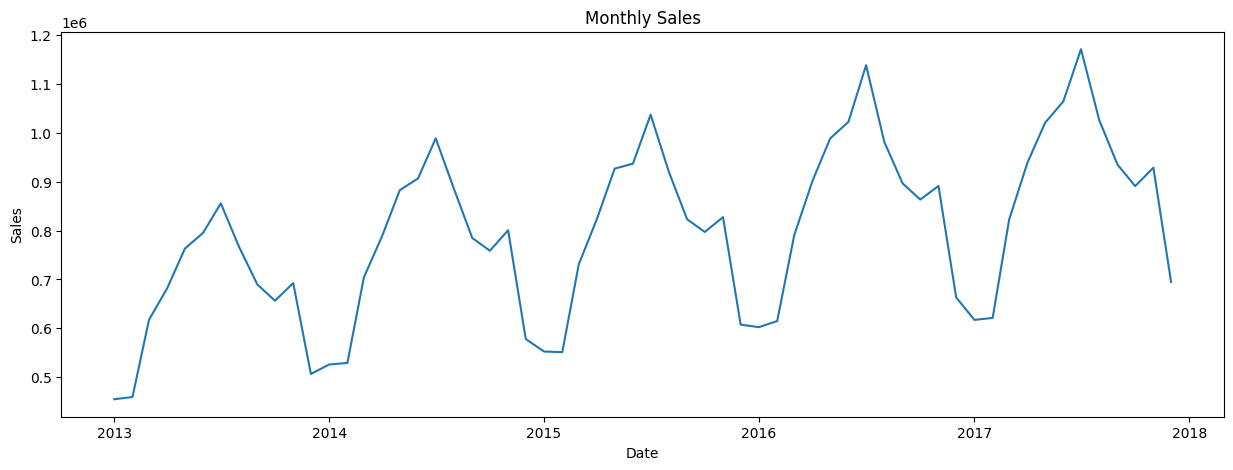

In [141]:
# Visualizing our data
plt.figure(figsize=(15, 5))
plt.plot(monthly_sales['date'], monthly_sales['sales'])
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Monthly Sales')
plt.show()

In [142]:
# Call the difference on the sales columns to make the sales data stationary
monthly_sales['sales_diff'] = monthly_sales['sales'].diff()
monthly_sales = monthly_sales.dropna()
monthly_sales.head(10)

,date,sales,sales_diff
1,2013-02-01,459417,4513.0
2,2013-03-01,617382,157965.0
3,2013-04-01,682274,64892.0
4,2013-05-01,763242,80968.0
5,2013-06-01,795597,32355.0
6,2013-07-01,855922,60325.0
7,2013-08-01,766761,-89161.0
8,2013-09-01,689907,-76854.0
9,2013-10-01,656587,-33320.0
10,2013-11-01,692643,36056.0


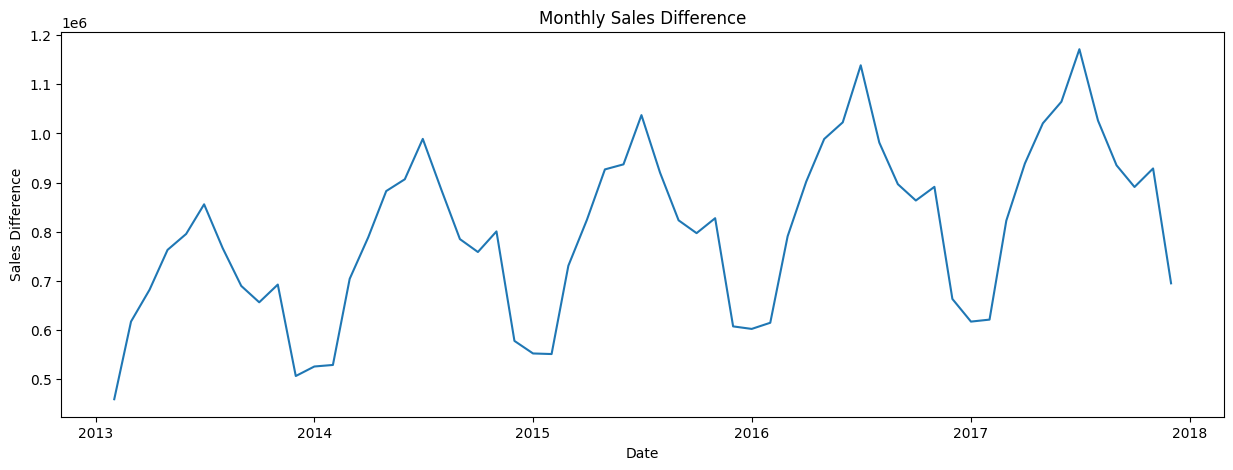

In [143]:
plt.figure(figsize=(15, 5))
plt.plot(monthly_sales['date'], monthly_sales['sales'])
plt.xlabel('Date')
plt.ylabel('Sales Difference')
plt.title('Monthly Sales Difference')
plt.show()

In [144]:
# Dropping off sales and date
supervised_data = monthly_sales.drop(['date', 'sales'], axis = 1)


In [145]:
# Preparing the supervised data
for i in range(1, 11):
  col_name = 'month_' + str(i)
  supervised_data[col_name] = supervised_data['sales_diff'].shift(i)
supervised_data = supervised_data.dropna().reset_index(drop=True)
supervised_data.head(10)

,sales_diff,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10
0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0,4513.0
1,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0
2,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0
3,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0
4,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0
5,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0
6,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0
7,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0
8,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0
9,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0


In [146]:
# Split the data into Training and Test sets
train_data = supervised_data[:-12]
test_data = supervised_data[-12:]
print("Train Data shape: ", train_data.shape)
print("Test Data shape: ", test_data.shape)

Train Data shape:  (37, 11)
Test Data shape:  (12, 11)


In [147]:
# Use scaler to transform the data
scaler = MinMaxScaler(feature_range = (-1,1))
scaler.fit(train_data)
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

In [148]:
X_train, y_train = train_data[:, 1:], train_data[:, 0:1]
X_test, y_test = test_data[:, 1:], test_data[:, 0:1]
y_train = y_train.ravel()
y_test = y_test.ravel()
print("X_train Shape", X_train.shape)
print("y_train Shape", y_train.shape)
print("X_test Shape", X_test.shape)
print("y_test Shape", y_test.shape)

X_train Shape (37, 10)
y_train Shape (37,)
X_test Shape (12, 10)
y_test Shape (12,)


Make prediciton data frame to merge the predicted sales prices of all trained algorithms


In [149]:
sales_dates = monthly_sales['date'][-12:].reset_index(drop=True)
predict_df = pd.DataFrame(sales_dates)

In [150]:
act_sales = monthly_sales['sales'][-13:].to_list()
print(act_sales)

[663411, 617306, 621369, 822667, 938862, 1020686, 1064624, 1171393, 1026403, 935263, 891160, 928837, 695170]


In [151]:
# Create the linear regression model and predicted output
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pre = lr_model.predict(X_test)

In [152]:
lr_pre = lr_pre.reshape(-1, 1)
# Set matrix - contains the input features of the test data and predicted output
lr_pre_test_set = np.concatenate((lr_pre, X_test), axis=1)
lr_pre_test_set = scaler.inverse_transform(lr_pre_test_set)

In [153]:
result_list = []
for index in range(0, len(lr_pre_test_set)):
  result_list.append(lr_pre_test_set[index][0] + act_sales[index])
lr_pre_series = pd.Series(result_list, name='Linear Prediction')
predict_df = predict_df.merge(lr_pre_series, left_index = True, right_index = True)

In [154]:
lr_mse = np.sqrt(mean_squared_error(predict_df['Linear Prediction'], monthly_sales['sales'][-12:]))
lr_mae = mean_absolute_error(predict_df['Linear Prediction'], monthly_sales['sales'][-12:])
lr_r2 = r2_score(predict_df['Linear Prediction'], monthly_sales['sales'][-12:])
print("Linear Regression MSE: ", lr_mse)
print("Linear Regression MAE: ", lr_mae)
print("Linear Regression R2: ", lr_r2)

Linear Regression MSE:  38258.677268822204
Linear Regression MAE:  35041.92988838488
Linear Regression R2:  0.9466075813097787


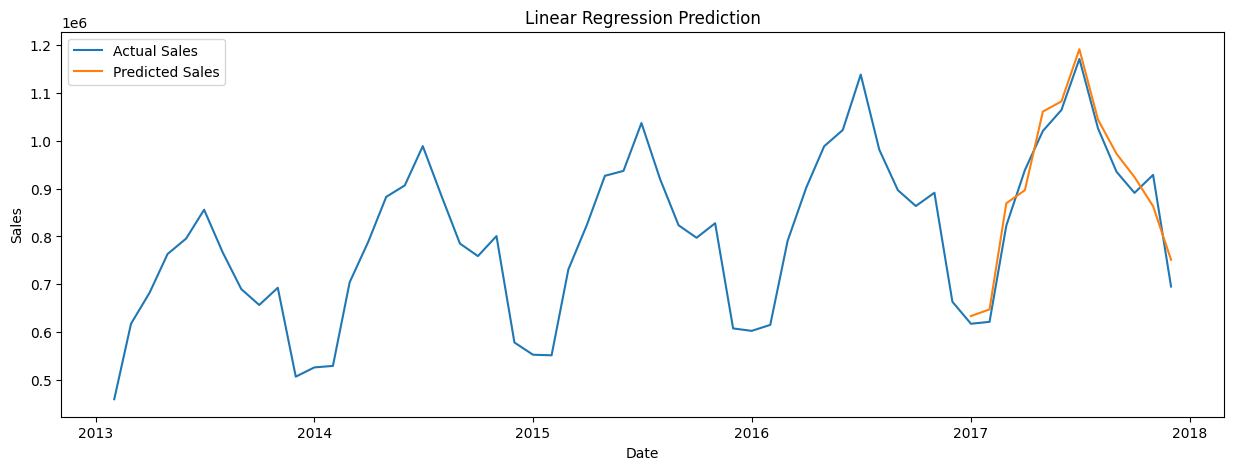

In [155]:
# Visualize the prediction
plt.figure(figsize=(15, 5))
# Actual sales
plt.plot(monthly_sales['date'], monthly_sales['sales'])
# Predicted sales
plt.plot(predict_df['date'], predict_df['Linear Prediction'])
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Linear Regression Prediction')
plt.legend(['Actual Sales', 'Predicted Sales'])
plt.show()